# Covid-19 Lethality estimation using data from Our World in Data datsets


### Disclaimer:
> This is not a scientific analyses, neither a rigorous work. This notebook has the sole purpose of showing up some techniques and analyses that one could make using COVID-19 public datasets and optimization techniques

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import CovidUtils as cv
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [2]:
df = cv.get_full_DataSet()

In [3]:
code = ['ISR']

In [4]:
cols=['date','new_cases_smoothed','new_deaths_smoothed',
      'people_fully_vaccinated_per_hundred','people_vaccinated_per_hundred']
dd = cv.get_country(df, 
                 cols=cols,
                 code=code)

start = dd.date.min()-pd.to_timedelta(40,'days')
end = dd.date.min()-pd.to_timedelta(1,'days')
drange = pd.date_range(start,end,freq='D')
filler = {c:'' for c in cols}

filler['date'] = drange
for c in cols[1:]: filler[c] = len(drange)*[0] 

    
dd=pd.concat([pd.DataFrame(filler),dd],axis=0)
dd.fillna(0,inplace=True)

dd.people_fully_vaccinated_per_hundred = dd.people_fully_vaccinated_per_hundred/100
dd.people_vaccinated_per_hundred = dd.people_vaccinated_per_hundred/100

# dd = dd[dd.date>pd.to_datetime('2020-06-01')]
dd = dd.set_index('date').rolling(15).mean().reset_index().fillna(0)

## Modeling a decay function

We know that covid doesn't affect you right after infection.

The most probable time window where symptoms can evolve to a serious and lethal illness are after the first week reaching a peak 15 days after infection.

That being said, we can model a function that weights the risk of the disease after its diagnosis as 

$f(t) = e^{-(t-\alpha)^2/\beta}$

Where paramters $\alpha$ and $\beta$ denote respectively how many days after diagnose the disease reach it's peak lethalithy rate and how narrow this time window is.

In [5]:
decay_sharp = 15
def decay(x):
    return 1*np.exp((-(x-15)**2)/decay_sharp)

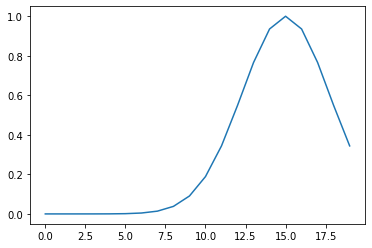

In [6]:
x = np.arange(20)
y = decay(x)
plt.plot(x,y);

# Carryover function

> A carry-over effect is any effect from a previous event that carries over onto a period after it has been terminated.

When talking about a disease the number of deaths on a given time $t$ depends not only on the number of diagnoses of the day $t$, given by $c_t$, but even more in the number of diagnoses in past days.

We can say that the total amount of cases contrbuting for the deaths in day t is a function $f(c_t, c_{t-1}, ... , c_{t-15})$

In [7]:
n = 40
lethal = 1

vaxeffect = 15


lethal_decay = lethal*decay(np.arange(2*n))
# lethal_decay = np.ones(2*n)

dates = list(range(n+1))

pvaxed = dd.people_fully_vaccinated_per_hundred.shift(vaxeffect).fillna(0).values
halfvaxed = dd.people_vaccinated_per_hundred.shift(vaxeffect).fillna(0).values - pvaxed

pantivax = 1 - halfvaxed - pvaxed

new_cases_smoothed = dd.new_cases_smoothed.values

carryover_cases = np.array([new_cases_smoothed[i-n:i] if len(new_cases_smoothed[i-n:i])>0 else np.zeros(n) 
                            for i in range(new_cases_smoothed.shape[0])])

carryover_vax = np.array([pvaxed[i-n:i] if len(pvaxed[i-n:i])>0 else np.zeros(n) 
                            for i in range(pvaxed.shape[0])])
carry_over_vax = [carryover_cases[i]*np.flip(lethal_decay[:n])*carryover_vax[i] 
                  for i in range(carryover_cases.shape[0])]

carryover_halfvax = np.array([halfvaxed[i-n:i] if len(halfvaxed[i-n:i])>0 else np.zeros(n) 
                            for i in range(halfvaxed.shape[0])])
carry_over_halfvax = [carryover_cases[i]*np.flip(lethal_decay[:n])*carryover_halfvax[i] 
                  for i in range(carryover_cases.shape[0])]


carryover_anti_vax = np.array([pantivax[i-n:i] if len(pantivax[i-n:i])>0 else np.ones(n) 
                               for i in range(carryover_cases.shape[0])])
carryover_anti_vax = np.array([carryover_cases[i]*np.flip(lethal_decay[:n])*carryover_anti_vax[i] 
                               for i in range(carryover_cases.shape[0])])


carry_over_vax = np.sum(carry_over_vax,axis=1)
carry_over_halfvax = np.sum(carry_over_halfvax,axis=1)
carryover_anti_vax = np.sum(carryover_anti_vax,axis=1)

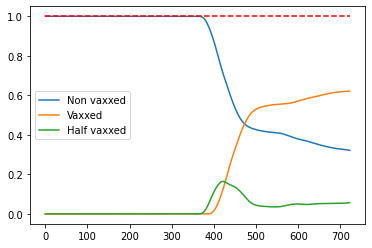

In [8]:
p_antivax = np.array([pantivax[i-n:i] if len(pantivax[i-n:i])>0 else np.ones(n) 
                      for i in range(carryover_cases.shape[0])]).mean(axis=1)

p_vax = np.array([pvaxed[i-n:i] if len(pvaxed[i-n:i])>0 else np.zeros(n) 
                  for i in range(pvaxed.shape[0])]).mean(axis=1)

p_halfvax = np.array([halfvaxed[i-n:i] if len(halfvaxed[i-n:i])>0 else np.zeros(n) 
                      for i in range(halfvaxed.shape[0])]).mean(axis=1)

x = np.arange(p_antivax.shape[0])

plt.plot(x,p_antivax, label='Non vaxxed');
plt.plot(x,p_vax, label='Vaxxed');
plt.plot(x,p_halfvax, label='Half vaxxed');
plt.plot(x,p_antivax + p_halfvax + p_vax, 'r--');

plt.legend()

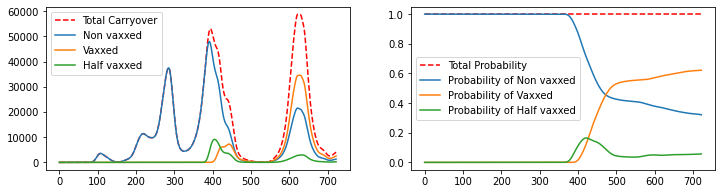

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,3))

x = np.arange(p_antivax.shape[0])

ax1.plot(x,carryover_anti_vax + carry_over_vax + carry_over_halfvax, 'r--', label='Total Carryover');

ax1.plot(x,carryover_anti_vax, label='Non vaxxed');
ax1.plot(x,carry_over_vax, label='Vaxxed');
ax1.plot(x,carry_over_halfvax, label='Half vaxxed');


ax2.plot(x,p_antivax + p_halfvax + p_vax, 'r--', label='Total Probability');
ax2.plot(x,p_antivax, label='Probability of Non vaxxed');
ax2.plot(x,p_vax, label='Probability of Vaxxed');
ax2.plot(x,p_halfvax, label='Probability of Half vaxxed');

ax1.legend();
ax2.legend();

In [10]:
dd['carry_over_vax'] = carry_over_vax
dd['carry_over_halfvax'] = carry_over_halfvax
dd['carryover_anti_vax'] = carryover_anti_vax

dd['pvaxed'] = pvaxed
dd['halfvaxed'] = halfvaxed
dd['pantivax'] = pantivax

In [11]:
# dd = dd[(dd.date>pd.to_datetime('2020-07-01'))&(dd.date<pd.to_datetime('2021-01-01'))]
dd = dd[(dd.date>pd.to_datetime('2020-07-01'))]

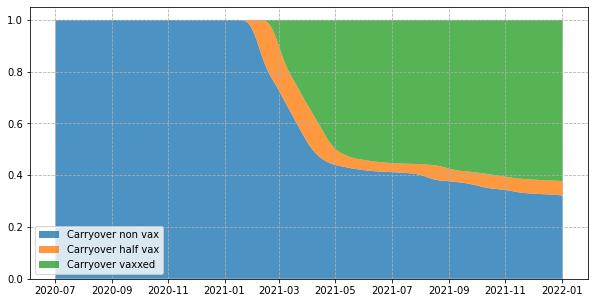

In [12]:
stack = dd.set_index('date')[['carryover_anti_vax','carry_over_halfvax','carry_over_vax']]

stack = stack.divide(stack.sum(axis=1), axis=0)

fig, ax1 = plt.subplots(1,1, figsize=(10,5))

ax1.stackplot(stack.index,
              [stack['carryover_anti_vax'], stack['carry_over_halfvax'],stack['carry_over_vax']],
              labels=['Carryover non vax', 'Carryover half vax', 'Carryover vaxxed'],
              alpha=0.8);

ax1.legend(loc='lower left');
ax1.grid(linestyle='--');

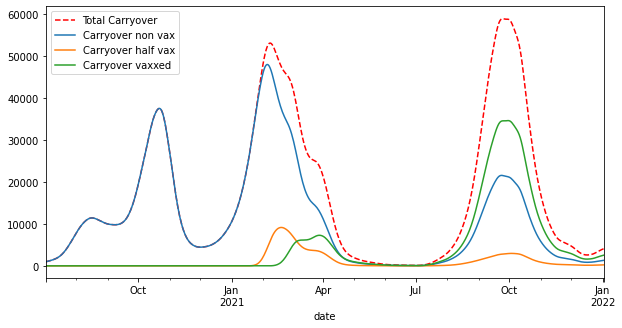

In [13]:
fig, ax1 = plt.subplots(1,1, figsize=(10,5))

dd.set_index('date')[['carryover_anti_vax','carry_over_halfvax','carry_over_vax']
                    ].sum(axis=1).plot(ax=ax1, label='Total Carryover', c='r', linestyle='--');

dd.set_index('date')['carryover_anti_vax'].plot(ax=ax1, label='Carryover non vax');
dd.set_index('date')['carry_over_halfvax'].plot(ax=ax1, label='Carryover half vax');
dd.set_index('date')['carry_over_vax'].plot(ax=ax1, label='Carryover vaxxed');

ax1.legend();

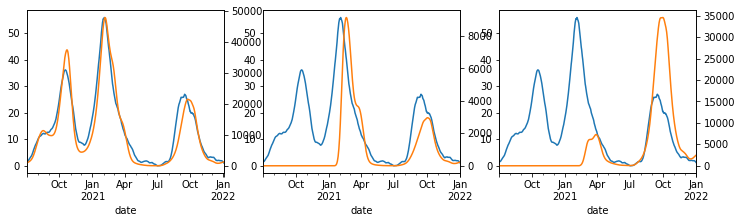

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,3))

dd.set_index('date')['new_deaths_smoothed'].plot(ax=ax1);
dd.set_index('date')['carryover_anti_vax'].plot(ax=ax1,secondary_y=True);

dd.set_index('date')['new_deaths_smoothed'].plot(ax=ax2);
dd.set_index('date')['carry_over_halfvax'].plot(ax=ax2,secondary_y=True);

dd.set_index('date')['new_deaths_smoothed'].plot(ax=ax3);
dd.set_index('date')['carry_over_vax'].plot(ax=ax3,secondary_y=True);

In [15]:
X = dd[['carry_over_vax','carry_over_halfvax','carryover_anti_vax']]
y = dd[['new_deaths_smoothed']]

# Non-Linear Model

In [16]:
vax = dd.carry_over_vax.values
ant = dd.carryover_anti_vax.values
half = dd.carry_over_halfvax.values

y = dd.new_deaths_smoothed.values

l = 0.03
e = 0.95
r = 1.0

x0 = [l,e,r]

In [17]:
def deaths(x):
    return vax*(1-x[1])*x[0] + ant*x[0] + half*(1-x[1]/x[2])*x[0]

def fitness(x):
    return np.sqrt(((y - deaths(x)) ** 2).mean())

In [18]:
fitness(x0)

481.6885037773881

In [19]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

In [20]:
bounds = Bounds([1e-3, 0.0, 1.0], [1e-1, 1.0, np.inf])

In [21]:
sol = minimize(fitness, x0=x0, method='L-BFGS-B',bounds=bounds,options={'gtol': 1e-6, 'disp': True})

l, e, r = sol.x
print(sol)
print(fitness(sol.x))

      fun: 3.9172289377466325
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.13038476e-03,  1.15463194e-06,  5.23199842e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 17
     njev: 24
   status: 0
  success: True
        x: array([0.00115416, 0.97163196, 1.        ])
3.9172289377466325


In [22]:
dd['pred_deaths'] = deaths(sol.x)

correlation_matrix = np.corrcoef(deaths(sol.x)[2*n:], y[2*n:])
correlation_xy = correlation_matrix[0,1]
r_squared = np.round(100*correlation_xy**2,2)

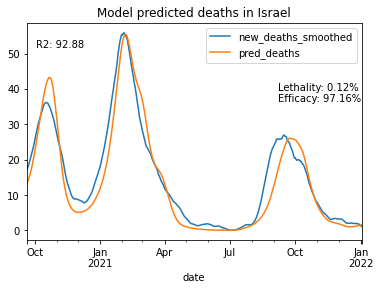

In [23]:
cname = df[df.iso_code.isin(code)]['location'].iloc[0]

fig, ax = plt.subplots()

dd.set_index('date')[['new_deaths_smoothed','pred_deaths']][2*n:].plot(ax=ax);

ax.set_title(f'Model predicted deaths in {cname}');

ax.text(0.1,0.9,f'R2: {r_squared}',ha='center', va='center', transform=ax.transAxes);

ax.text(0.75,0.7,f'Lethality: {round(100*l,2)}%',ha='left', va='center', transform=ax.transAxes);
ax.text(0.75,0.65,f'Efficacy: {round(100*e,2)}%',ha='left', va='center', transform=ax.transAxes);

In [24]:
daily_lethality = l*decay(np.arange(60))

estimated = round(100*(1-np.prod(1-daily_lethality)),2)

actual = round(100*dd.new_deaths_smoothed.sum()/dd.new_cases_smoothed.sum(),2)

print(f'Covid-19 estimated Lethality: {estimated}%\nCovid-19 actual Lethality: {actual}%')

Covid-19 estimated Lethality: 0.79%
Covid-19 actual Lethality: 0.59%
